In [1]:
import os 
os.chdir("..")
from src.cpwc.multires.class_multiressolver import *
import matplotlib.pyplot as plt
import torch
from src.cpwc.tools.ptychography import Ptychography as Ptychography
from src.cpwc.tools.utils import *

# Set seeds 
torch.manual_seed(0)
np.random.seed(0)


/home/efe/Desktop/Multiresolution-Framework-for-Fourier-Ptychography/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
max_scale = 7
max_probe_size = 32
max_shift = 8
device = 'cuda'
I_in = 15*np.array([1, 15, 10, 5, 10, 30, 100])
I_out = 5*np.array([0, 0, 0, 30, 30,40,100])
cycle = [0, -1, -1, -1,  1, 1, 1]
lmbda = 0
LR = 1e-3
tol = [1e-10] * 9
tol_in = [1e-10] * 9

linOperator = Ptychography(max_scale = max_scale,max_probe_size = max_probe_size ,max_shift = max_shift,device=device)

image = plt.imread('test_data/peppers_reduced.jpg')/ 255
image_tensor = torch.tensor(image).double().to(device).view(1, 1, 2**max_scale, 2**max_scale)
image_tensor_ = torch.exp(1j * image_tensor)
multires = MultiRes(max_scale, device)
#loss = Loss(linOperator,linOperator.apply(image_tensor_), lmbda = lmbda)
loss = Loss(linOperator,linOperator.apply(image_tensor_))
model = MultiResSolver(multires, loss, LR = LR,
                        I_in = I_in,
                        I_out = I_out,
                        tol = tol,
                        tol_in = tol_in,
                        cycle = cycle,
                        l1_type = "l1_row")

model.solve_multigrid()
model.print_time()


Scale: 7, n_copies: 1
----------- s = 7 -----------
----------- s = 6 -----------
Scale: 6, n_copies: 2
----------- s = 5 -----------
Scale: 5, n_copies: 4
----------- s = 4 -----------
Scale: 4, n_copies: 8
Iter 1, [loss, mse, reg, rel_loss, LR] : [12093.090111, 12093.090111, 5.8e-06, 0.001] 
Iter 2, [loss, mse, reg, rel_loss, LR] : [12093.0200801, 12093.0200801, 7.5e-06, 0.001] 
Iter 3, [loss, mse, reg, rel_loss, LR] : [12092.9299531, 12092.9299531, 1.23e-05, 0.001] 
Iter 4, [loss, mse, reg, rel_loss, LR] : [12092.781467, 12092.781467, 2.03e-05, 0.001] 
Iter 5, [loss, mse, reg, rel_loss, LR] : [12092.5355641, 12092.5355641, 3.44e-05, 0.001] 
Iter 6, [loss, mse, reg, rel_loss, LR] : [12092.1192265, 12092.1192265, 6e-05, 0.001] 
Iter 7, [loss, mse, reg, rel_loss, LR] : [12091.3935827, 12091.3935827, 0.0001079, 0.001] 
Iter 8, [loss, mse, reg, rel_loss, LR] : [12090.0888248, 12090.0888248, 0.0002001, 0.001] 
Iter 9, [loss, mse, reg, rel_loss, LR] : [12087.6695387, 12087.6695387, 0.00038

KeyboardInterrupt: 

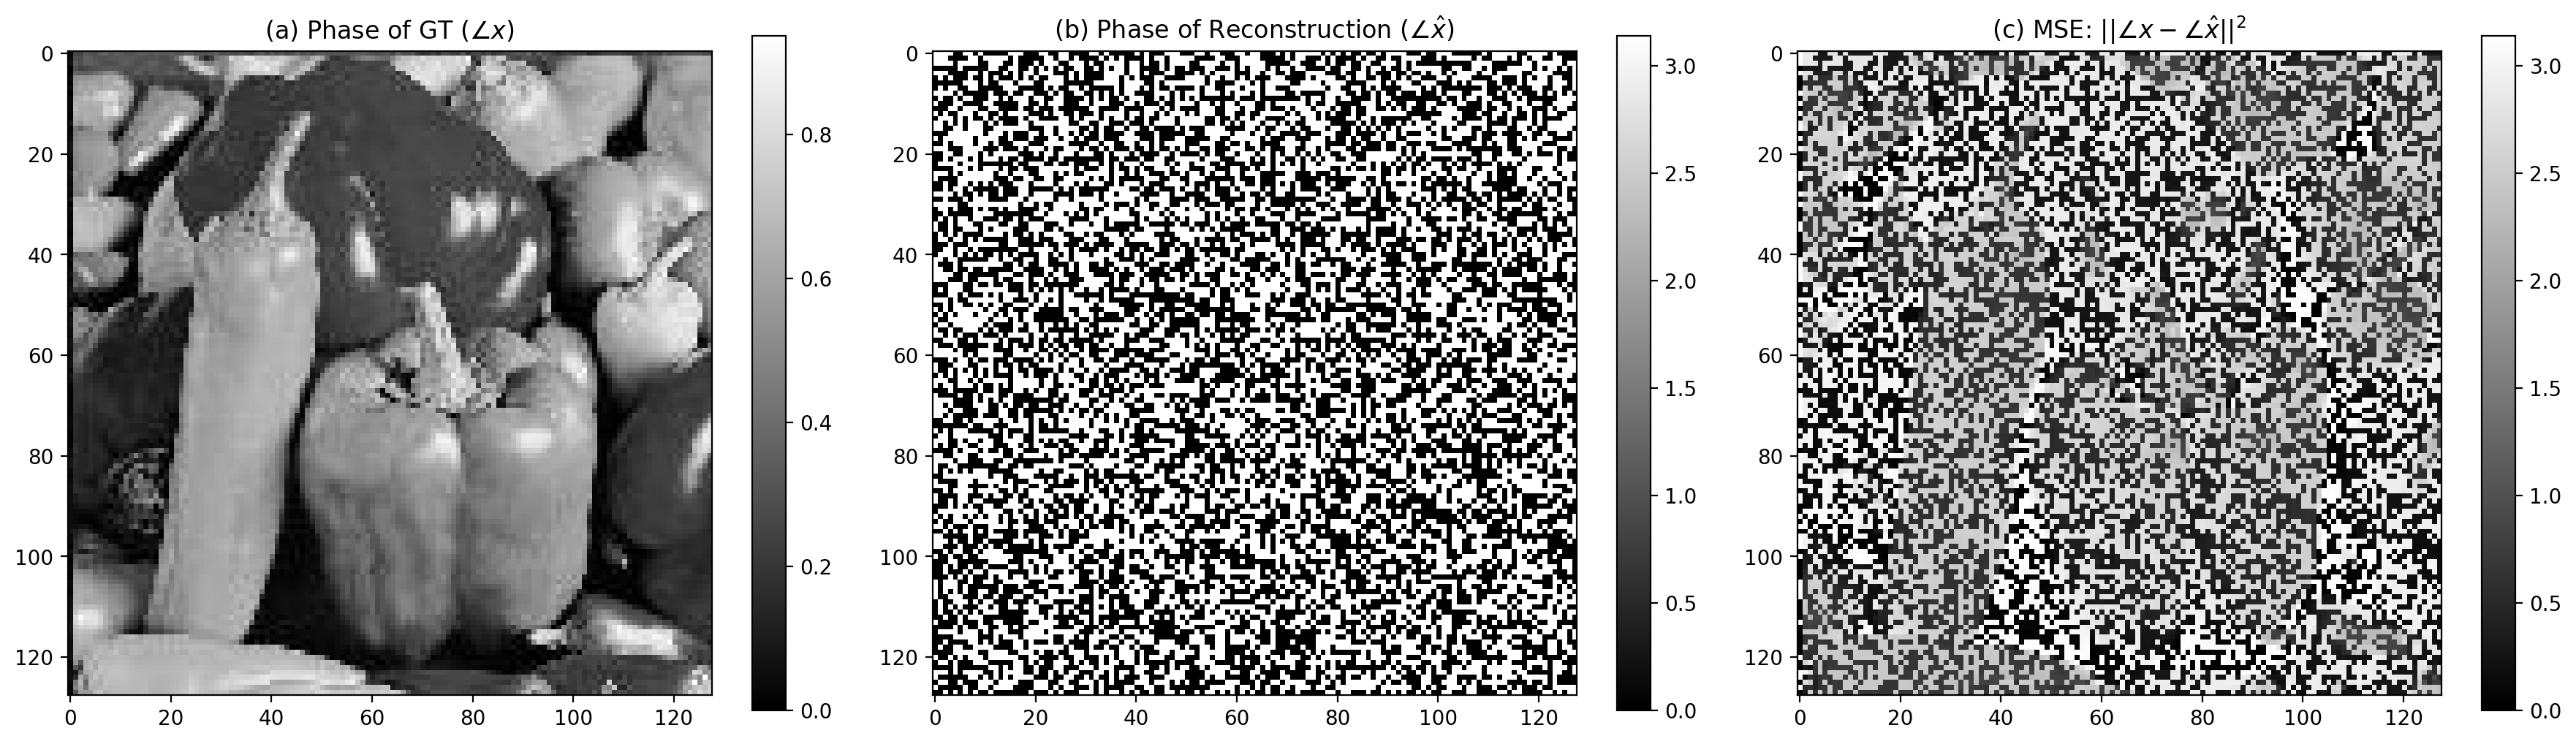

In [5]:
def extract_data(nested_list):
    result = []
    for item in nested_list:
        if isinstance(item, list):  # If the item is a list, recurse into it
            result.extend(extract_data(item))
        else:  # If the item is not a list, add it to the result
            result.append(item)
    return result


def unwrap_2d(phase):
    """
    Unwraps a 2D phase array using NumPy's 1D unwrap function.
    
    Parameters:
    phase (numpy array): The 2D phase array to be unwrapped.
    
    Returns:
    unwrapped_phase (numpy array): The 2D unwrapped phase array.
    """
    # Unwrap along the first axis (rows)
    unwrapped_phase = np.unwrap(phase, axis=0)
    
    # Unwrap along the second axis (columns)
    unwrapped_phase = np.unwrap(unwrapped_phase, axis=1)
    
    return unwrapped_phase

def plot_results(model,image):
    plt.figure(figsize=(18, 5),dpi = 200)    

    plt.subplot(1, 3, 1)
    plt.imshow(image,cmap='gray')
    plt.title(r"(a) Phase of GT $(\angle x)$")
    plt.colorbar()


    plt.subplot(1, 3, 2)
    phase = torch.angle(model.sols[-1][0,0,:,:].to('cpu'))
    phase = unwrap_2d(phase)
    phase = (phase - np.min(phase))/(np.max(phase) - np.min(phase))
    plt.imshow(phase,cmap = 'gray')
    plt.title(r"(b) Phase of Reconstruction $(\angle \hat{x})$")
    plt.colorbar()


    plt.subplot(1, 3, 3)
    plt.imshow(np.abs(np.array(image)-np.array(phase)),cmap='gray')
    plt.title(r"(c) MSE: $||\angle x - \angle \hat{x}||^2$")
    plt.colorbar()
    plt.tight_layout()
    #plt.savefig("n_figs/new_result_img.png")
    #plt.savefig("n_figs/new_result_img.eps")

    return None 

plot_results(model,image)


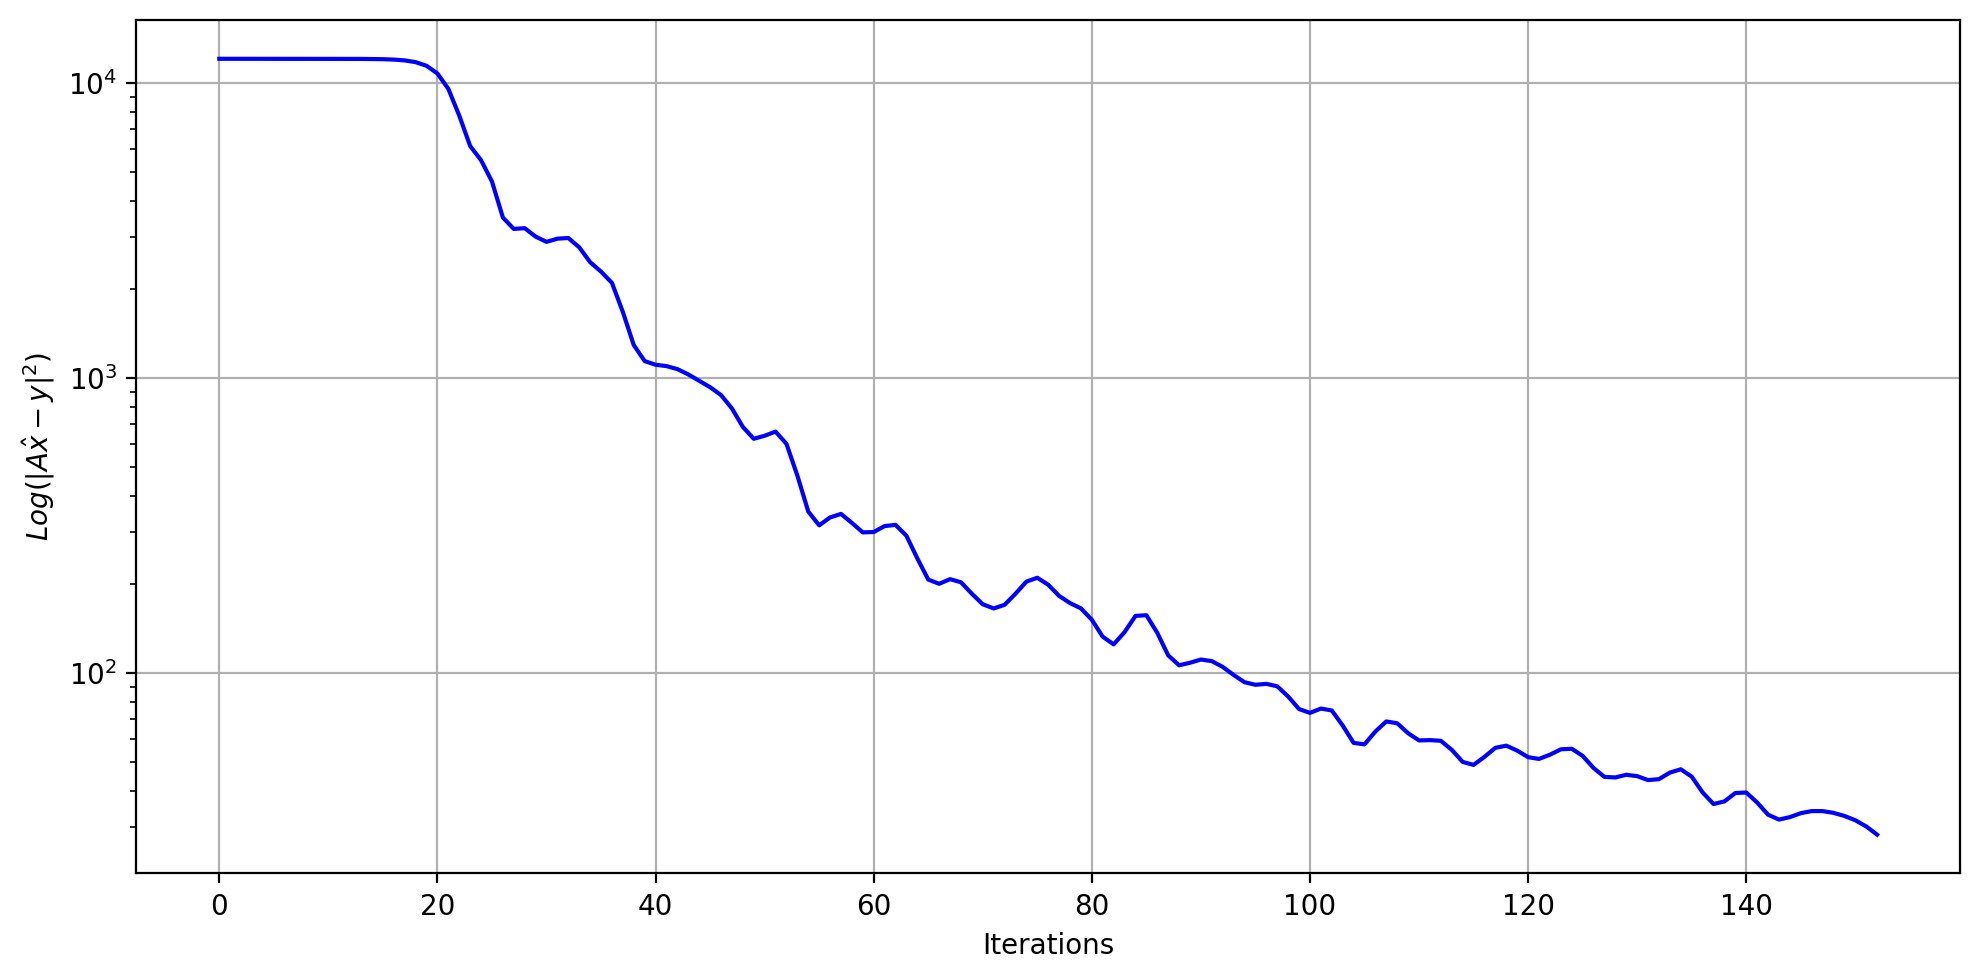

In [6]:
plt.figure(figsize=(10, 5),dpi = 200)
plt.semilogy(extract_data(model.measures["loss"]),label = "Loss",color = 'blue')
plt.xlabel("Iterations")
plt.ylabel(r"$Log(|A\hat{x}-y|^2)$")
plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
max_scale = 7
max_probe_size = 32
max_shift = 8
device = 'cuda'
I_in = 15*np.array([1, 15, 10, 5, 10, 30, 100])
I_out = 40*np.array([0, 0, 0, 30, 10,10,100])
cycle = [0, -1, -1, -1,  1, 1, 1]
lmbda = 0
LR = 1e-2
tol = [1e-10] * 9
tol_in = [1e-10] * 9

linOperator = Ptychography(max_scale = max_scale,max_probe_size = max_probe_size ,max_shift = max_shift,device=device)

image = plt.imread('images/peppers_reduced.jpg')/ 255
image_tensor = torch.tensor(image).double().to(device).view(1, 1, 2**max_scale, 2**max_scale)
image_tensor_ = torch.exp(1j * image_tensor)
multires = MultiRes(max_scale, device)
#loss = Loss(linOperator,linOperator.apply(image_tensor_), lmbda = lmbda)
loss = Loss(linOperator,linOperator.apply(image_tensor_))
model1 = MultiResSolver(multires, loss, LR = LR,
                        I_in = I_in,
                        I_out = I_out,
                        tol = tol,
                        tol_in = tol_in,
                        cycle = cycle,
                        l1_type = "l1_row")

model1.solve_multigrid()
model1.print_time()

In [ ]:
max_scale = 7
max_probe_size = 32
max_shift = 8
device = 'cuda'
I_in = 15*np.array([1, 15, 10, 5, 10, 30, 100])
I_out = 40*np.array([0, 0, 0, 0, 0,0,150])
cycle = [0, -1, -1, -1,  1, 1, 1]
lmbda = 0
LR = 1e-2
tol = [1e-10] * 9
tol_in = [1e-10] * 9

linOperator = Ptychography(max_scale = max_scale,max_probe_size = max_probe_size ,max_shift = max_shift,device=device)

image = plt.imread('images/peppers_reduced.jpg')/ 255
image_tensor = torch.tensor(image).double().to(device).view(1, 1, 2**max_scale, 2**max_scale)
image_tensor_ = torch.exp(1j * image_tensor)
multires = MultiRes(max_scale, device)
#loss = Loss(linOperator,linOperator.apply(image_tensor_), lmbda = lmbda)
loss = Loss(linOperator,linOperator.apply(image_tensor_))
model2 = MultiResSolver(multires, loss, LR = LR,
                        I_in = I_in,
                        I_out = I_out,
                        tol = tol,
                        tol_in = tol_in,
                        cycle = cycle,
                        l1_type = "l1_row")

model2.solve_multigrid()
model2.print_time()

In [ ]:
plt.figure(figsize=(10, 5),dpi = 200)
plt.semilogy(extract_data(model2.measures["loss"]),label = "Loss Classical GD",color = 'red')
plt.semilogy(extract_data(model1.measures["loss"]),label = "Loss Multiresolution GD",color = 'blue')
plt.xlabel("Iterations")
plt.ylabel(r"$Log(|A\hat{x}-y|^2)$")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()